# Data Science Analysis: Predicting Popularity of User Movie Reviews on Letterboxd

## Group 100
   
   >Sarina Singh
   >
   >Jackson Barnier
   >
   >Benjamin Cah
   >
   >Soham Barve
   
## Introduction

Letterboxd is a popular film cataloging site centered around user-created content. Users rate and then often also review movies that they have seen. Users are able to "like" other users reviews, which increases their visibility on the site. Additionally, they can also leave comments on any user's review. We would like to examine which factors are most significant in determining the number of interactions that a review receives. 

## Purpose 

Letterboxd reviews are the focus of the entire community. Thus, it is entirely possible that a set of users who write popular reviews are able to influence the general consensus about a film in the community. Additionally, our analysis should enable us to determine whether someone can "craft" a popular (or controversial) review. In other words, to what extent is popularity organic? 

Some of the questions we will explore in this analysis are as follows:
   > Do positive reviews resonate with users more than negative reviews? Through sentiment positive/negative/neutral.
   >
   > Are long reviews or short reviews preferred by users? 
   >
   > Do specific words in the content of a review resonate more with users leading to more likes, what are these words?

# 1.0 Data Preparation & Exploration

## Importing Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import RFE
from sklearn.impute import SimpleImputer

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.preprocessing import LabelEncoder

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

from sklearn.feature_selection import RFE, RFECV

import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import re
import string

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def disp_pearson(x, y, **kws):
    corrmat = np.corrcoef(x,y)
    pearson = round(corrmat[0, 1], 2)
    ax = plt.gca()
    ax.annotate(pearson, [.5, .5], xycoords = "axes fraction", ha = "center", va='center', fontsize = 30)

## Importing Data

In [3]:
#Reading csv files
data = pd.read_csv("data/finalData.csv", na_values="NA???") #imported csv data

## Dataset
We scraped Letterboxd using Beautiful Soup and the requests library in order to create a sample of user reviews for analysis. All films were randomly selected from the top 115 pages of most popular films. Our dataset contains 60 randomly selected user reviews for each film. 

Each row in the dataset corresponds to a single user review. We recorded the following variables corresponding to each user review:

* Full review text
* Number of likes on review
* Number of comments on review
* Number of followers for the author of the review 
* Number of users that the author of the review follows
* Date user posted review on the site
   
In addition to the review-level variables, the dataset also contains the following information about each film included in our study: 

* Title
* Year
* Length in minutes
* Genres 
* Spoken languages
* Associated countries
* Number of "fans" for the film
* Rating breakdown (number of ratings for each rating level from 0.5 to 5)

The selection of variables involved considering any factors that may affect how users engage with the reviews on Letterboxd. For example, users with a high follower count are likely to get more "likes" on their reviews since their content has higher visibility. On a film-level, users who watch longer films may also be more tolerant of longer and more detailed reviews. Our goal is to identify which of these variables actually predict popularity. 

In [4]:
data.columns

Index(['Film Title', 'Film Year', 'Film Length', 'Genre 1', 'Genre 2',
       'Genre 3', 'Genre 4', 'Language 1', 'Language 2', 'Language 3',
       'Language 4', 'Country 1', 'Country 2', 'Country 3', 'Country 4',
       'Total Ratings', 'Number of Fans', 'Average Ratings', '0.5 Rating',
       '1.0 Rating', '1.5 Rating', '2.0 Rating', '2.5 Rating', '3.0 Rating',
       '3.5 Rating', '4.0 Rating', '4.5 Rating', '5.0 Rating', 'Review Text',
       'Number of Paragraphs', 'Number of Likes', 'Comments', 'Followers',
       'Following', 'Date'],
      dtype='object')

In [5]:
data.shape

(5339, 35)

In [6]:
data.head()

,Film Title,Film Year,Film Length,Genre 1,Genre 2,Genre 3,Genre 4,Language 1,Language 2,Language 3,...,4.0 Rating,4.5 Rating,5.0 Rating,Review Text,Number of Paragraphs,Number of Likes,Comments,Followers,Following,Date
0,Memories of Underdevelopment,1968,99,drama,,,,Spanish,English,,...,1170,623,495,"Unbelievably fresh, even today.",1,5,0,113,191,7-Aug-19
1,Memories of Underdevelopment,1968,99,drama,,,,Spanish,English,,...,1170,623,495,A curious take at the Cuban revolution. Regul...,1,2,0,37,39,24-Jul-20
2,Memories of Underdevelopment,1968,99,drama,,,,Spanish,English,,...,1170,623,495,"""But I have seen too much to be innocent. And...",1,3,0,13,37,26-Oct-19
3,Memories of Underdevelopment,1968,99,drama,,,,Spanish,English,,...,1170,623,495,Extraordinary collage of intellectual and pol...,2,31,2,209,"7,702",1/07/2013
4,Memories of Underdevelopment,1968,99,drama,,,,Spanish,English,,...,1170,623,495,politics and poetry aside...sergio is a piece...,1,3,0,159,241,26-Sep-19


## 1.1 Data Preparation

In [7]:
#remove formatting issues with follower numbers
data['Followers']=(data['Followers'].str.replace(',','')).astype('int64')
data['Following']=(data['Following'].str.replace(',','')).astype('int64')
#rename variables in place for readability
data.rename(columns={"Number of Likes": "Likes", "Review Text": "Review", "Number of Fans": "Fans","Film Title":"Title","Film Length":"Length","Film Year":"Year","Number of Paragraphs":"Paragraphs"}, inplace=True)

In [8]:
data['Count'] = data['Review'].apply(lambda x: len(str(x).split(" ")))
print("Word Count Median: " + str(data['Count'].median()))
print(data['Count'].describe())

Word Count Median: 64.0
count    5339.000000
mean      138.697322
std       211.018377
min         2.000000
25%        21.000000
50%        64.000000
75%       171.000000
max      3791.000000
Name: Count, dtype: float64


In [9]:
#need to remove word "Fans" and add thousands where appropriate
data['Fans'].unique()

array(['56 fans', '399 fans', '16 fans', '5.7k fans', '260 fans', '0',
       '2 fans', '1.6k fans', '222 fans', '7 fans', '14 fans', '372 fans',
       '3.7k fans', '48 fans', '12 fans', '40 fans', '67 fans',
       '101 fans', '20 fans', '15 fans', '13k fans', '39 fans', '29 fans',
       '11 fans', '209 fans', '45 fans', '24 fans', '396 fans', '57 fans',
       '13 fans', '88 fans', '150 fans', '133 fans', '41 fans',
       '792 fans', '94 fans', '6 fans', '8 fans', '38 fans', '305 fans',
       '62 fans', '1 fan', '5k fans', '17 fans', '3 fans', '23k fans',
       '9 fans', '208 fans', '86 fans', '236 fans', '137 fans',
       '103 fans', '253 fans', '44 fans', '28 fans', '92 fans', '23 fans',
       '35 fans', '5 fans', '598 fans', '189 fans', '145 fans', '70 fans',
       '80 fans', '53 fans', '10 fans', '674 fans', '55 fans'],
      dtype=object)

In [10]:
#remove word "Fans" and add thousands where appropriate
data['Fans'] = (data['Fans'].str.split()).str[0]
data['Fans'] = data['Fans'].str.replace('k','000')
data['Fans'] = data['Fans'].astype('str') 
#https://stackoverflow.com/questions/33769860/pandas-apply-but-only-for-rows-where-a-condition-is-met
mask = (data['Fans'].str.contains('.',regex=False))
data_valid = data[mask]
data.loc[mask, 'Fans'] = data_valid['Fans'].str[:-1]
data['Fans'] = data['Fans'].str.replace('.','')
data['Fans'] = data['Fans'].astype(int)
data['Fans'].unique()

array([   56,   399,    16,  5700,   260,     0,     2,  1600,   222,
           7,    14,   372,  3700,    48,    12,    40,    67,   101,
          20,    15, 13000,    39,    29,    11,   209,    45,    24,
         396,    57,    13,    88,   150,   133,    41,   792,    94,
           6,     8,    38,   305,    62,     1,  5000,    17,     3,
       23000,     9,   208,    86,   236,   137,   103,   253,    44,
          28,    92,    23,    35,     5,   598,   189,   145,    70,
          80,    53,    10,   674,    55])

In [11]:
data.dtypes

Title               object
Year                 int64
Length               int64
Genre 1             object
Genre 2             object
Genre 3             object
Genre 4             object
Language 1          object
Language 2          object
Language 3          object
Language 4          object
Country 1           object
Country 2           object
Country 3           object
Country 4           object
Total Ratings        int64
Fans                 int32
Average Ratings    float64
0.5 Rating           int64
1.0 Rating           int64
1.5 Rating           int64
2.0 Rating           int64
2.5 Rating           int64
3.0 Rating           int64
3.5 Rating           int64
4.0 Rating           int64
4.5 Rating           int64
5.0 Rating           int64
Review              object
Paragraphs           int64
Likes                int64
Comments             int64
Followers            int64
Following            int64
Date                object
Count                int64
dtype: object

#### Adding Sentiment


In [12]:
#IMDB movie review Kaggle dataset
#code adapted from Kaggle code
#https://www.kaggle.com/sachinsharma1123/90-precent-accuracy-score-using-simple-nlp-model

#import movie review dataset with known sentiment
IMDB_sent = pd.read_csv("data/IMDB.csv", na_values="NA???") 
IMDB_sent.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [13]:
def custom_preprocessor(text):  
    '''
    Make text lowercase, remove text in square brackets,remove links,remove special characters
    and remove words containing numbers.
    '''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) # remove special chars
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    return text

In [14]:
IMDB_sent['review']=IMDB_sent['review'].apply(custom_preprocessor)

In [15]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
IMDB_sent['sentiment']=le.fit_transform(IMDB_sent['sentiment'])

In [16]:

X_train, X_test, y_train, y_test = train_test_split(IMDB_sent['review'],IMDB_sent['sentiment'],test_size=0.2)

from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(ngram_range=(1,2))
X_train_trans=cv.fit_transform(X_train)
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
lr.fit(X_train_trans,y_train)
pred_y=lr.predict(cv.transform(X_test))
from sklearn.metrics import accuracy_score
score_1=accuracy_score(y_test,pred_y)
score_1

C:\Users\soham\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9088

In [17]:
print(X_test)

13857    my first full heston movie  the movie that eve...
25623    it s rare for a film to sweep you away within ...
1013     this movie is a real low budget production  ye...
6251     since watching the trailer in  the little merm...
29503    first one has to take into account the time pe...
                               ...                        
15642    my first review at imdb  after a few years of ...
15460    i thought the movie was actually pretty good  ...
8583     debbie reynolds toe taps  tangos and  yes  tap...
17176    i just didn t get this movie   was it a musica...
20034    poorly acted and poorly directed   congo  unsu...
Name: review, Length: 10000, dtype: object


In [18]:
data['Review']=data['Review'].apply(custom_preprocessor)
#cv=CountVectorizer(ngram_range=(1,2))
#data_trans=cv.fit_transform(data['review'])
#lr=LogisticRegression()
#lr.fit(X_train_trans,data['Sentiment'])
data['Sentiment']=lr.predict(cv.transform(data['Review']))

In [19]:
data['Sentiment']=le.inverse_transform(data['Sentiment'])

## 1.2 Data Exploration

#### Preliminary Numerical Observations -- change specific #s when full dataset included

The descriptive statistics below give us a general impression of the dataset. Some notable features include:
    
* the number of likes has a large range, but most reviews have a low number of likes
    * 75% of the reviews have under 29 likes, while the maximum is 9396
* the majority of reviews have 0 comments
* most reviews have no line breaks (one paragraph)
* the average rating varies by around a half star

In [20]:
data.describe()

,Year,Length,Total Ratings,Fans,Average Ratings,0.5 Rating,1.0 Rating,1.5 Rating,2.0 Rating,2.5 Rating,...,3.5 Rating,4.0 Rating,4.5 Rating,5.0 Rating,Paragraphs,Likes,Comments,Followers,Following,Count
count,5339.000000,5339.000000,5339.000000,5339.000000,5339.00000,5339.000000,5339.000000,5339.000000,5339.000000,5339.000000,...,5339.000000,5339.000000,5339.000000,5339.000000,5339.000000,5339.000000,5339.000000,5339.000000,5339.000000,5339.000000
mean,1997.550290,105.186364,40775.685334,669.352875,3.37732,315.053381,705.087844,616.109009,2021.825435,2087.497846,...,5614.824499,10559.087844,4936.122495,8016.336954,2.556284,52.648623,2.289755,738.618281,3176.153774,138.697322
std,22.841264,35.688091,92701.891457,2873.127092,0.54976,845.754150,1608.352884,1174.818361,3922.316276,3498.443087,...,10170.386999,26881.572378,14409.352750,29458.696560,3.135083,234.812914,8.197665,3137.179589,7897.617006,211.018377
min,1927.000000,2.000000,2357.000000,0.000000,2.12000,1.000000,3.000000,6.000000,37.000000,58.000000,...,281.000000,138.000000,15.000000,38.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,1991.000000,95.000000,5731.000000,11.000000,3.03000,16.000000,56.000000,59.000000,299.000000,394.000000,...,1022.000000,944.000000,256.000000,254.000000,1.000000,5.000000,0.000000,100.000000,317.000000,21.000000
50%,2004.000000,105.000000,11453.000000,39.000000,3.49000,52.000000,148.000000,175.000000,717.000000,903.000000,...,1946.000000,2369.000000,636.000000,748.000000,1.000000,11.000000,0.000000,240.000000,867.000000,64.000000
75%,2015.000000,116.000000,32420.000000,137.000000,3.85000,234.000000,710.000000,678.000000,2085.000000,2209.000000,...,5688.000000,6310.000000,1791.000000,2312.000000,3.000000,29.000000,2.000000,511.000000,2318.000000,171.000000
max,2020.000000,332.000000,494243.000000,23000.000000,4.37000,6571.000000,12539.000000,8887.000000,31617.000000,27355.000000,...,53814.000000,162735.000000,79471.000000,218085.000000,93.000000,9396.000000,238.000000,80184.000000,76074.000000,3791.000000


## 1.2.1 Univariate Exploration
In order to determine how to approach our analysis, we want to examine the behavior of some key variables in our dataset. Our ultimate goal for analysis is to **determine the factors that predict higher interactions.** In other words, the primary variables of interest are **likes** and **comments**. 

### Distribution of Likes and Comments 
The distribution of likes and comments are very similar: both are concentrated at the lower range of values but contain very high-value outliers. There are many more high outliers in comments than likes indicating tha much of the information is not as valuable. Both are positively skewed with comments being almost totally positively skewed.These observations are confirmed by the stripplot and boxplots below

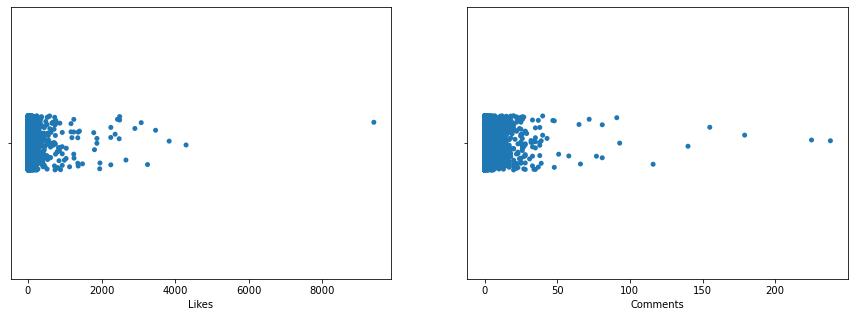

In [21]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
sns.stripplot(data['Comments'], ax=axs[1])
sns.stripplot(data['Likes'], ax=axs[0])

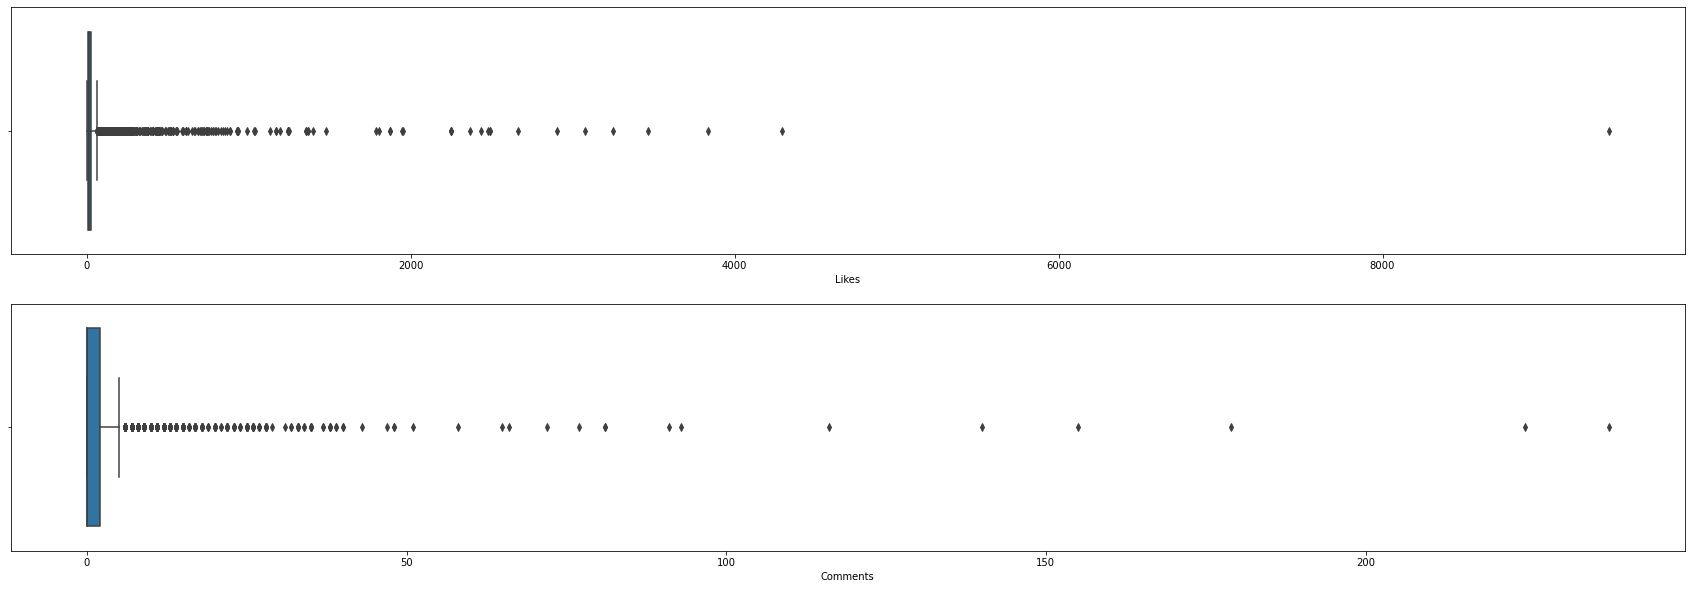

In [22]:
fig, axs = plt.subplots(2,1,figsize=(30,10))
sns.boxplot(data['Comments'], ax=axs[1])
sns.boxplot(data['Likes'], ax=axs[0])

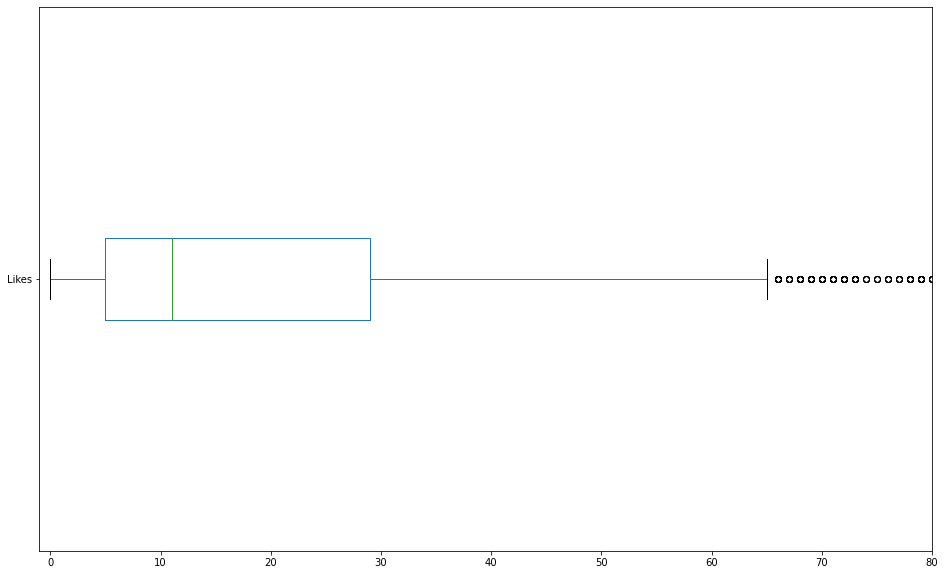

In [23]:
plt.rcParams["figure.figsize"] = [16,10]
data['Likes'].plot.box(vert=False)

#Setting ylim to improve distribution visibility
plt.xlim(-1,80)
plt.show()

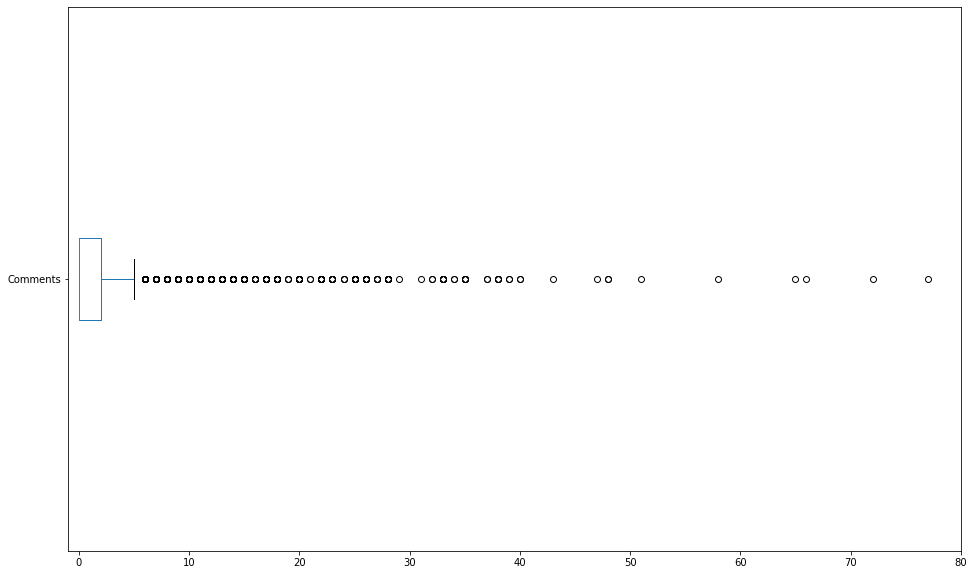

In [24]:
data.Comments.plot.box(vert=False)

#Setting ylim to improve distribution visibility
plt.xlim(-1,80)
plt.show()

### Distribution of Paragraphs and WordCount

The distribution of Paragraphs and Wordcount is again similar: both are concentrated at the lower range of values and contain  high-value outliers. Both are positively skewed but paragraphs is almost totally skewed. Further more the whiskers of Word Count are much than that of paragraphs indicating a much greater range in the data. This observation is confirmed by the stripplot and boxplots below.

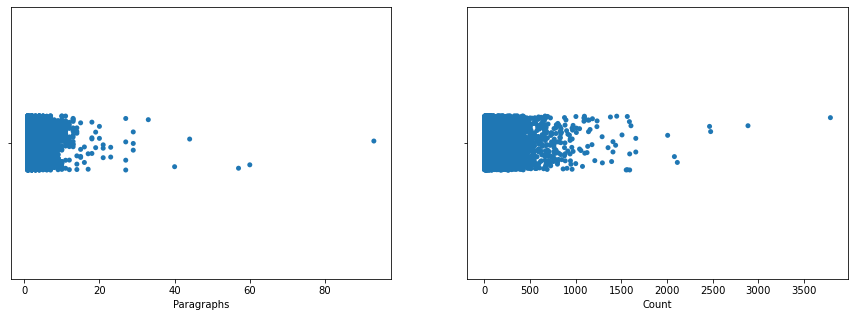

In [25]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
sns.stripplot(data['Count'], ax=axs[1])
sns.stripplot(data['Paragraphs'], ax=axs[0])

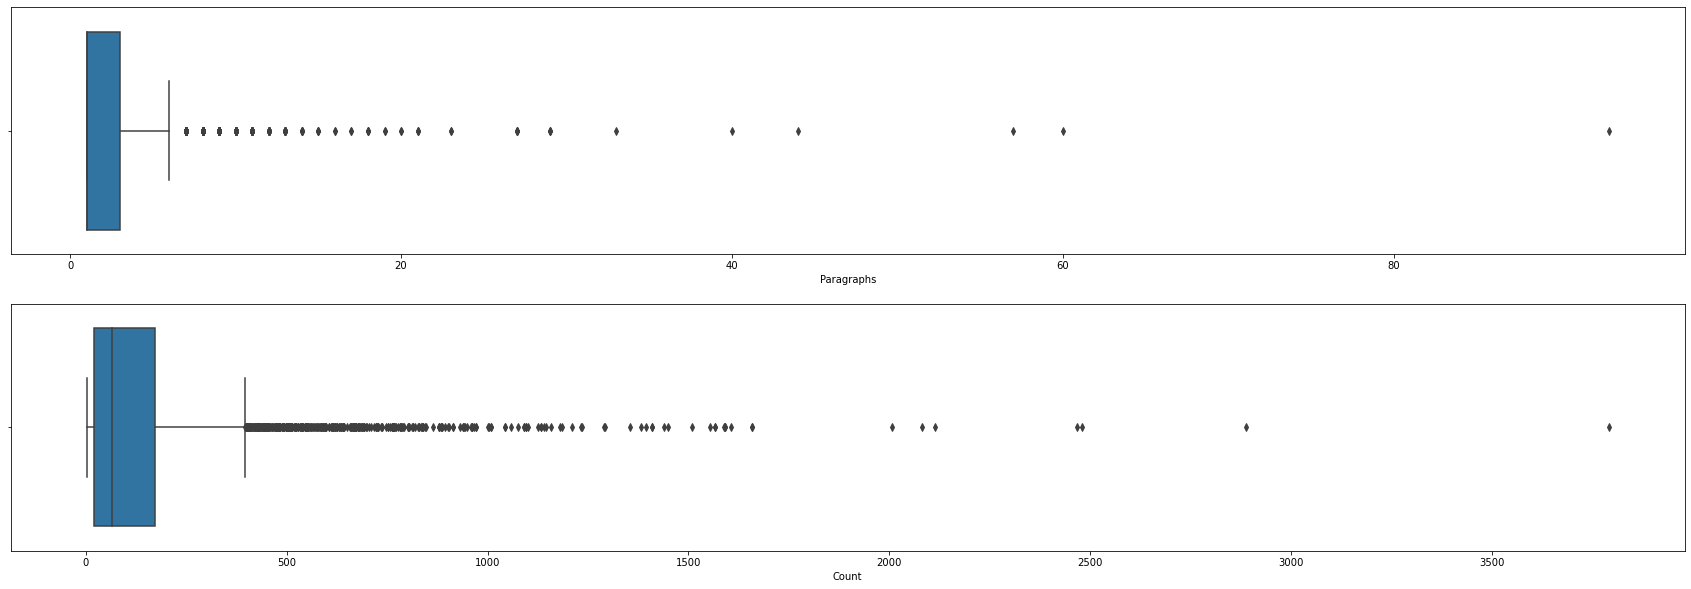

In [26]:
fig, axs = plt.subplots(2,1,figsize=(30,10))
sns.boxplot(data['Count'], ax=axs[1])
sns.boxplot(data['Paragraphs'], ax=axs[0])

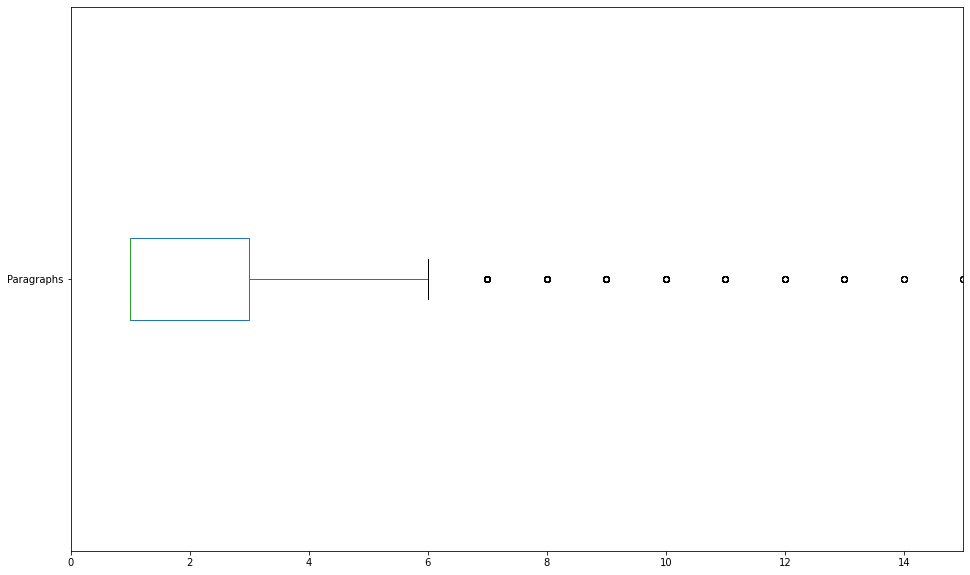

In [27]:
data['Paragraphs'].plot.box(vert=False)

#Setting ylim to improve distribution visibility
plt.xlim(0,15)
plt.show()

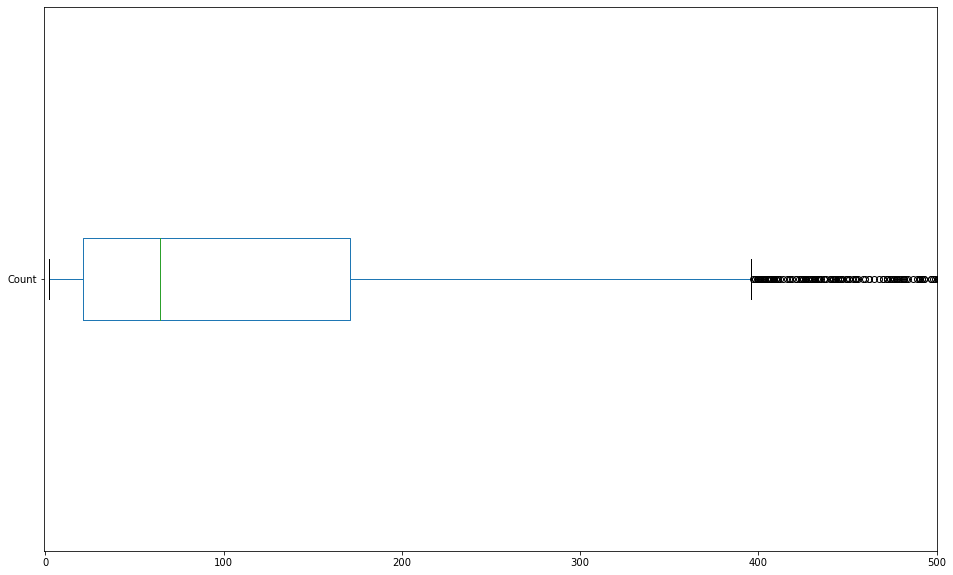

In [28]:
data['Count'].plot.box(vert=False)

#Setting ylim to improve distribution visibility
plt.xlim(-1,500)
plt.show()

### Distribution of Followers and Following

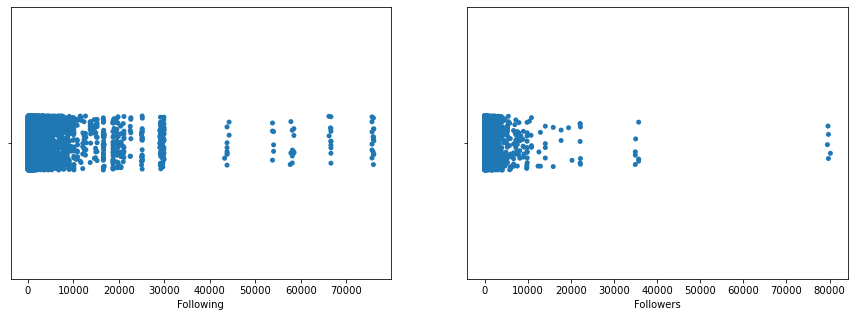

In [29]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
sns.stripplot(data['Followers'], ax=axs[1])
sns.stripplot(data['Following'], ax=axs[0])

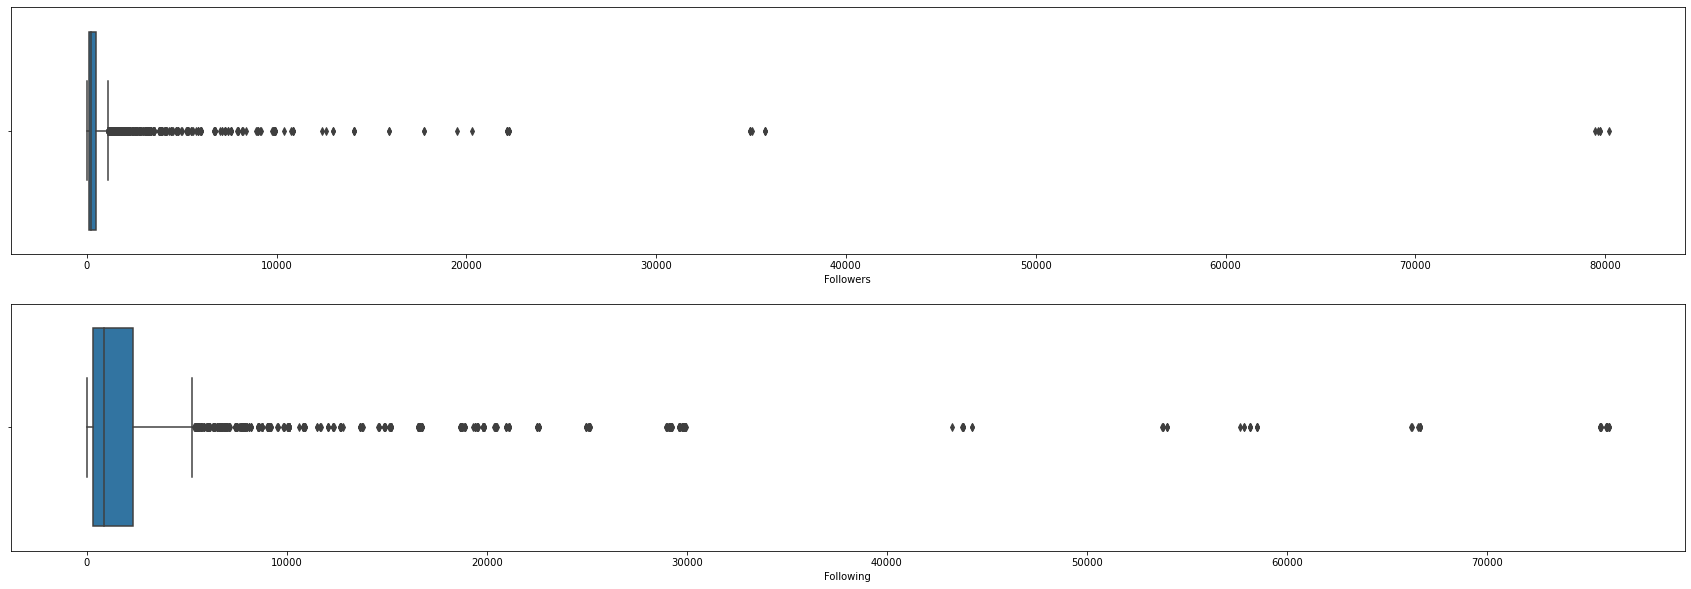

In [30]:
fig, axs = plt.subplots(2,1,figsize=(30,10))
sns.boxplot(data['Following'], ax=axs[1])
sns.boxplot(data['Followers'], ax=axs[0])

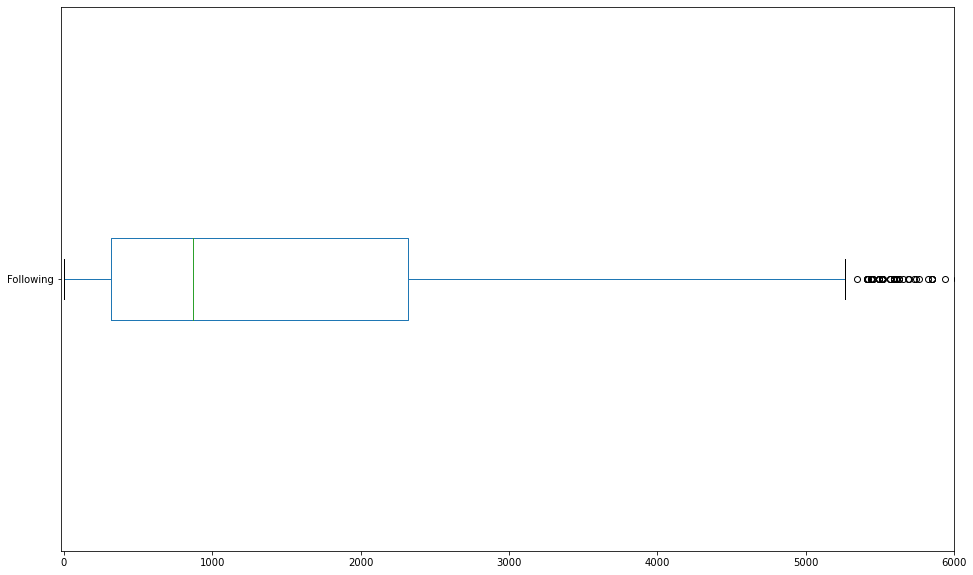

In [31]:
data['Following'].plot.box(vert=False)

#Setting ylim to improve distribution visibility
plt.xlim(-20,6000)
plt.show()

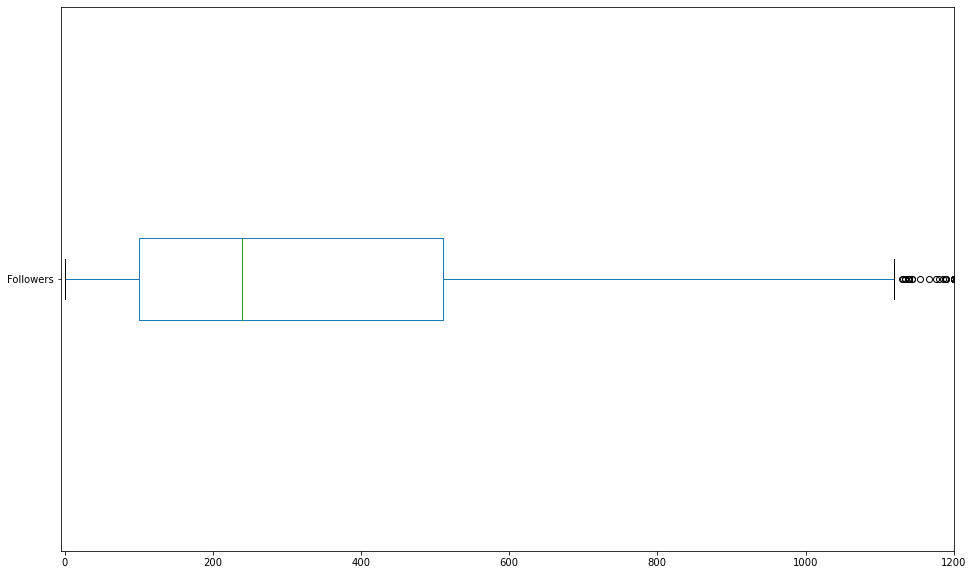

In [32]:
data['Followers'].plot.box(vert=False)

#Setting ylim to improve distribution visibility
plt.xlim(-5,1200)
plt.show()

Through the plots presented above we see a very broad overview, however, as can be seen the boxplots, outliers decrease the visibility of valuable data. There are many high outliers in all this data indicating that the data will not provide the greatest information.

By setting a limit on the xaxis to narrow down the number of outliers displayed, we can display the data quartiles (or percentiles) and averages with improved visibility.

### 1.2.2 Multivariate Exploration
We want to explore our dataset and which factors are correlated, to do so effectively pairsplots are applied, scatterplots, histograms and 

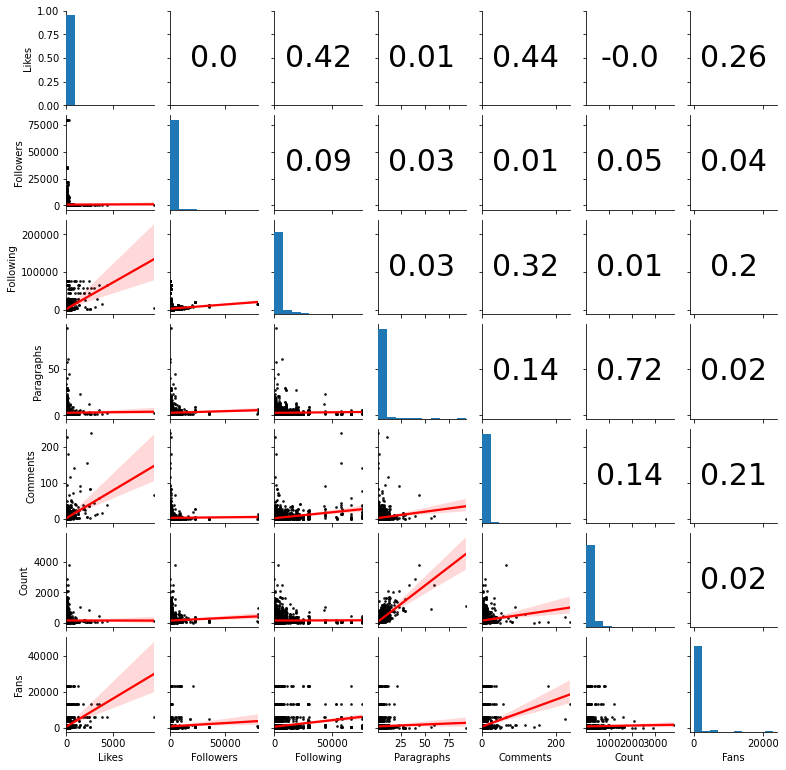

In [33]:
# Pairplots
scatterdata = data[['Likes','Followers','Following', 'Paragraphs', 'Comments', 'Count', 'Fans']]

s = sns.PairGrid(scatterdata, height = 1.5)
s = s.map_diag(plt.hist)
s = s.map_lower(sns.regplot, color = 'k', scatter_kws={"s":3}, line_kws={'color' :'r'})
s = s.map_upper(disp_pearson)

#### Comments:
-There are particularly strong correlations between consecutive ratings (ie: a 3 and 3.5 rating).

In [34]:
# Correlation matrix
data.corr()

,Year,Length,Total Ratings,Fans,Average Ratings,0.5 Rating,1.0 Rating,1.5 Rating,2.0 Rating,2.5 Rating,...,3.5 Rating,4.0 Rating,4.5 Rating,5.0 Rating,Paragraphs,Likes,Comments,Followers,Following,Count
Year,1.000000,-0.149154,0.185520,0.073875,-0.380913,0.199094,0.221088,0.253765,0.250516,0.277354,...,0.226610,0.167360,0.144266,0.100082,-0.024668,0.111464,0.077809,0.034677,0.105593,-0.071027
Length,-0.149154,1.000000,0.133403,0.125449,0.164697,0.124878,0.130480,0.125397,0.139764,0.130581,...,0.115487,0.108804,0.118118,0.126829,0.082980,0.044948,0.080616,0.021511,0.054001,0.110063
Total Ratings,0.185520,0.133403,1.000000,0.808790,0.300143,0.454396,0.513079,0.446268,0.624630,0.622588,...,0.942354,0.983468,0.966972,0.919539,0.049048,0.353253,0.292103,0.042070,0.273813,0.044415
Fans,0.073875,0.125449,0.808790,1.000000,0.312880,0.166411,0.212701,0.135046,0.290557,0.271011,...,0.628360,0.766469,0.840568,0.925567,0.023448,0.255600,0.214082,0.039897,0.199550,0.017194
Average Ratings,-0.380913,0.164697,0.300143,0.312880,1.000000,-0.245116,-0.257169,-0.345563,-0.160104,-0.132456,...,0.299470,0.365282,0.391424,0.342856,0.043518,0.123578,0.082779,0.042607,0.084480,0.108847
0.5 Rating,0.199094,0.124878,0.454396,0.166411,-0.245116,1.000000,0.984511,0.933642,0.870681,0.798863,...,0.509002,0.356352,0.281758,0.216836,0.057015,0.204627,0.252649,0.010354,0.190713,0.016636
1.0 Rating,0.221088,0.130480,0.513079,0.212701,-0.257169,0.984511,1.000000,0.975547,0.933292,0.873364,...,0.570985,0.409616,0.329099,0.262886,0.054681,0.219669,0.261503,0.008326,0.201984,0.015018
1.5 Rating,0.253765,0.125397,0.446268,0.135046,-0.345563,0.933642,0.975547,1.000000,0.947285,0.905511,...,0.518840,0.334324,0.249516,0.183221,0.049424,0.194013,0.239518,0.004807,0.184906,0.008641
2.0 Rating,0.250516,0.139764,0.624630,0.290557,-0.160104,0.870681,0.933292,0.947285,1.000000,0.985732,...,0.711056,0.523908,0.430157,0.346849,0.061978,0.257947,0.287685,0.009835,0.232896,0.032112
2.5 Rating,0.277354,0.130581,0.622588,0.271011,-0.132456,0.798863,0.873364,0.905511,0.985732,1.000000,...,0.734507,0.527569,0.427470,0.331402,0.059651,0.265598,0.283688,0.013644,0.239612,0.035328


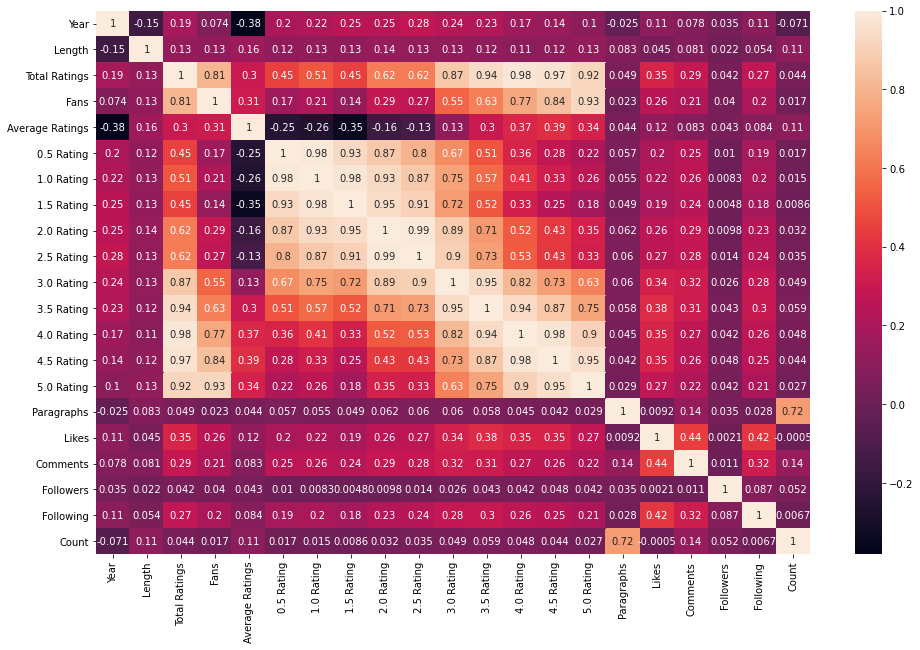

In [35]:
corrMatrix = data.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

#### Comments:
-The above heat map shows the strength of the consecutive correlations (as mentioned earlier).

# 2.0 Data Analysis

### Do positive reviews resonate more than negative reviews? Through sentiment positive/negative/neutral.

In [36]:
IMDB_sent = pd.read_csv("data/IMDB.csv", na_values="NA???") 
IMDB_sent.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [37]:
def custom_preprocessor(text):  
    '''
    Make text lowercase, remove text in square brackets,remove links,remove special characters
    and remove words containing numbers.
    '''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) # remove special chars
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    return text

IMDB_sent['review']=IMDB_sent['review'].apply(custom_preprocessor)

In [38]:
combined_dataframe = data.join(IMDB_sent, how = 'inner')

In [39]:
dfn123 = combined_dataframe[(combined_dataframe.sentiment == 'positive')]
dfn123.describe()

,Year,Length,Total Ratings,Fans,Average Ratings,0.5 Rating,1.0 Rating,1.5 Rating,2.0 Rating,2.5 Rating,...,3.5 Rating,4.0 Rating,4.5 Rating,5.0 Rating,Paragraphs,Likes,Comments,Followers,Following,Count
count,2642.000000,2642.000000,2642.000000,2642.000000,2642.000000,2642.000000,2642.000000,2642.000000,2642.000000,2642.000000,...,2642.000000,2642.000000,2642.000000,2642.000000,2642.000000,2642.000000,2642.000000,2642.000000,2642.000000,2642.000000
mean,1997.281605,105.340273,41001.629447,687.236942,3.377820,314.535201,702.460636,613.281605,2004.564724,2063.990537,...,5587.451552,10614.322483,5021.962907,8232.014383,2.581756,52.098410,2.331188,713.112793,3207.963285,141.538229
std,23.159363,34.722359,92897.932695,2948.948976,0.553795,844.691183,1606.456805,1177.446161,3893.224274,3460.321587,...,10014.040514,26765.002889,14543.578502,30197.026758,3.322547,209.842579,7.399950,2923.298150,7980.181564,223.637707
min,1927.000000,2.000000,2357.000000,0.000000,2.120000,1.000000,3.000000,6.000000,37.000000,58.000000,...,281.000000,138.000000,15.000000,38.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,1990.000000,95.000000,5901.000000,11.000000,3.030000,16.250000,57.000000,64.000000,304.000000,457.000000,...,1029.000000,944.000000,255.000000,254.000000,1.000000,5.000000,0.000000,100.000000,323.500000,22.000000
50%,2004.000000,105.000000,11453.000000,39.000000,3.490000,52.000000,148.000000,175.000000,717.000000,912.000000,...,1988.000000,2369.000000,636.000000,748.000000,1.000000,12.000000,0.000000,240.000000,882.000000,63.000000
75%,2015.000000,116.000000,32420.000000,137.000000,3.850000,234.000000,710.000000,678.000000,2085.000000,2027.000000,...,5688.000000,6310.000000,2094.000000,2312.000000,3.000000,29.000000,2.000000,511.000000,2269.000000,171.000000
max,2020.000000,332.000000,494243.000000,23000.000000,4.370000,6571.000000,12539.000000,8887.000000,31617.000000,27355.000000,...,53814.000000,162735.000000,79471.000000,218085.000000,93.000000,4294.000000,155.000000,79630.000000,76074.000000,3791.000000


(0.0, 4508.7)

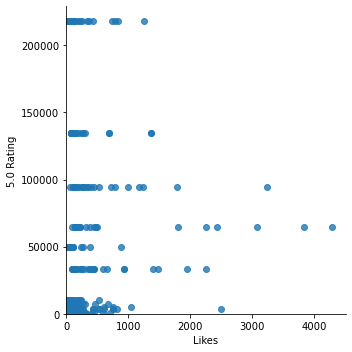

In [40]:
# Plot using Seaborn
sns.lmplot(x='Likes', y='5.0 Rating', data=dfn123,
           fit_reg=False)
 
# Tweak using Matplotlib
plt.ylim(0, None)
plt.xlim(0, None)

In [41]:
dfn123 = combined_dataframe[(combined_dataframe.sentiment == 'negative')]
dfn123.describe()

,Year,Length,Total Ratings,Fans,Average Ratings,0.5 Rating,1.0 Rating,1.5 Rating,2.0 Rating,2.5 Rating,...,3.5 Rating,4.0 Rating,4.5 Rating,5.0 Rating,Paragraphs,Likes,Comments,Followers,Following,Count
count,2697.000000,2697.000000,2697.000000,2697.000000,2697.00000,2697.000000,2697.000000,2697.000000,2697.000000,2697.000000,...,2697.000000,2697.000000,2697.000000,2697.000000,2697.000000,2697.000000,2697.000000,2697.000000,2697.000000,2697.000000
mean,1997.813496,105.035595,40554.348906,651.833519,3.37683,315.560994,707.661476,618.878754,2038.734149,2110.525769,...,5641.639229,10504.979607,4852.032629,7805.057842,2.531331,53.187616,2.249166,763.603634,3144.992955,135.914349
std,22.526486,36.615253,92526.138234,2797.296118,0.54588,846.950477,1610.501874,1172.450185,3951.256088,3535.878738,...,10323.035877,27000.130118,14278.838126,28721.061735,2.940281,256.970142,8.911337,3333.776282,7817.245499,197.879877
min,1927.000000,2.000000,2357.000000,0.000000,2.12000,1.000000,3.000000,6.000000,37.000000,58.000000,...,281.000000,138.000000,15.000000,38.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000
25%,1991.000000,95.000000,5656.000000,11.000000,3.03000,16.000000,56.000000,57.000000,270.000000,357.000000,...,1006.000000,903.000000,256.000000,254.000000,1.000000,6.000000,0.000000,102.000000,312.000000,20.000000
50%,2004.000000,105.000000,11453.000000,39.000000,3.49000,52.000000,148.000000,175.000000,717.000000,882.000000,...,1946.000000,2369.000000,636.000000,748.000000,1.000000,11.000000,0.000000,242.000000,849.000000,64.000000
75%,2015.000000,116.000000,32420.000000,137.000000,3.85000,284.000000,750.000000,749.000000,2110.000000,2449.000000,...,5823.000000,6310.000000,1791.000000,2312.000000,3.000000,29.000000,2.000000,519.000000,2351.000000,170.000000
max,2020.000000,332.000000,494243.000000,23000.000000,4.37000,6571.000000,12539.000000,8887.000000,31617.000000,27355.000000,...,53814.000000,162735.000000,79471.000000,218085.000000,60.000000,9396.000000,238.000000,80184.000000,76074.000000,2467.000000


(0.0, 9865.8)

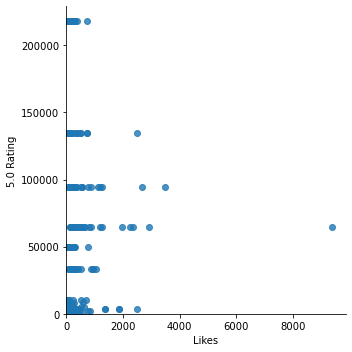

In [42]:
# Plot using Seaborn
sns.lmplot(x='Likes', y='5.0 Rating', data=dfn123,
           fit_reg=False)
 
# Tweak using Matplotlib
plt.ylim(0, None)
plt.xlim(0, None)

#### Comments:
Positive reviews do not resonate more than negative reviews. The counts and means are roughly the same for the number of likes and higher ratings (4.0, 4.5 and 5.0 star ratings) for both the positive and negative sentiments.

### Are long reviews or short reviews preferred by users?
We attempt to answer the question are long reviews or short reviews preferred by users, through examining the relationship between word count and likes we can take the average word count, and using a countplot we can visualise the count of likes reviews with a word count less than average receive compared to the count of likes reviews with a word count greater than average receive.

In [43]:
#word counts less than average wordcount
wcla = data.loc[data['Count'] <= 138]
print('Less than average word count')
print(wcla.Likes.describe())
print('')

#word counts less then
wcga = data.loc[data['Count'] > 138]
print('Greater than average word count')
print(wcga.Likes.describe())

Less than average word count
count    3699.000000
mean       57.021087
std       262.874919
min         0.000000
25%         5.000000
50%        10.000000
75%        27.000000
max      9396.000000
Name: Likes, dtype: float64

Greater than average word count
count    1640.000000
mean       42.786585
std       153.359613
min         0.000000
25%         7.000000
50%        14.000000
75%        32.000000
max      3466.000000
Name: Likes, dtype: float64


Text(0.5, 1.0, 'No. Likes Count equal to and less than average')

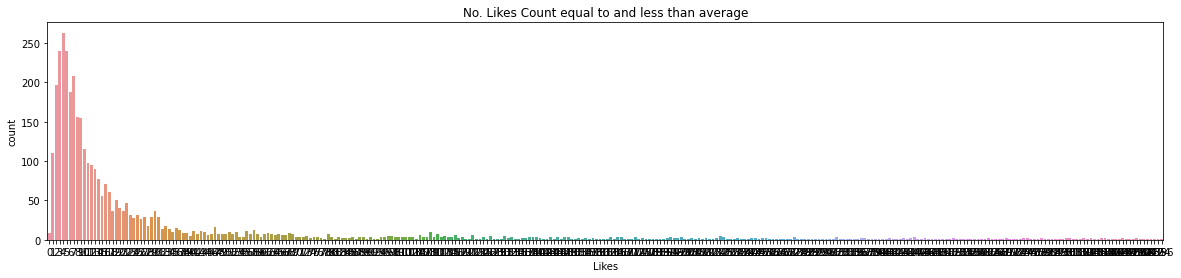

In [44]:
#plot the counts
plt.figure(figsize=(20,4))
sns.countplot(x ='Likes', data = wcla).set_title("No. Likes Count equal to and less than average")

Text(0.5, 1.0, 'No. Likes Count greater than average')

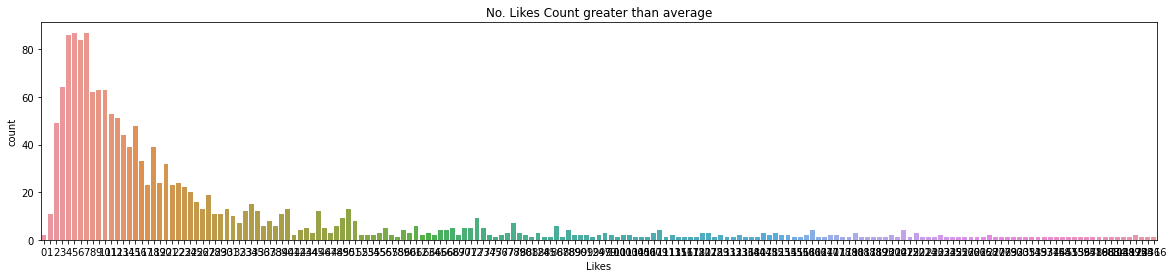

In [45]:
#plot the counts
plt.figure(figsize=(20,4))
sns.countplot(x ='Likes', data = wcga).set_title("No. Likes Count greater than average")

#### Comments:
> It seems that shorter reviews are preffered by users as visualised above. The count of likes for words =< the average word count receive more likes then reviews that are longer than average, this is relevant to our dataset and does not account for other predicators such as sentiment this also fails to account for the uneven nature of our data, as we likely have scraped more reviews that are shorter than average as they are the most frequent type of review. This can be appended through further improvement to our data scraping script which would scrape more balanced data. 

## 2.1 Clustering
As mentioned in our proposal by using K-means clustering we will develop clusters containing similar reviews. In our proposal we offered a range of vectors including: genre, word count, postive and negative reviews.

Upon revision clustering can be best utilised to determine the if the individual words in a review can be used to differentiate if the review has higher than average likes which brings us to our third question. 

### Do specific words in the content of a review resonate more with users leading to more likes, what are these words?
We are interested to find if the content of a review can be used to differentiate if the review will receive more likes, K-means clustering will be the method in which we will attempt to answer this question. Initially, we labelled our data according to above average likes and below average likes. Our output was less than satisfactory and upon the data exploration it was evident that specific reviews are causing our average to be inflated to 52. To counter this we used the 2nd quartile or the median which is independent of outliers which is the cause of inflation. 

To classify what is considered 'resonating more with users', any like value above the median of 11 likes is considered to resonate more with users. The way we will determine the answer to this question is the TF-IDF output of the most successful cluster, the success of a cluster is ultimately determined by the heatmap visualising the differences between '> median likes and < median likes'.

We examine clusters of words, pulled from our TF-IDF vectorisor which are then fit and clustered through KMeans clustering, N = 20 and the results are displayed through heatmaps to convey our result.

In [46]:
#add column to label records upon like count
data['best_words'] = [1 if Likes >= 11 else 0 for Likes in data['Likes']]

#### Vectorising the text using TF-IDF
Through TF-IDF we will determine how important a word is in each review

In [47]:
#TF-IDF vectorizer
v = TfidfVectorizer(max_features = 1000)
#transform
v_text = v.fit_transform(data.Review).toarray()
#generating a list containing all features
vword = v.get_feature_names()

#### Kmeans clustering
Declaration and fitting of K-Means 

In [48]:
#setup kmeans clustering
kmeans = KMeans(n_clusters = 20, random_state=142, n_jobs = -1, tol = 0.01, max_iter = 200)
#fit the data 
kmeans.fit(v_text)
#this loop transforms the numbers back into words
w = kmeans.cluster_centers_.argsort()[:,-1:-1000:-1]
for num, centroid in enumerate(w):
    print(str(num) + ' : ' + ', '.join(vword[word] for word in centroid))

C:\Users\soham\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


0 : me, this, to, the, and, it, of, in, movie, that, for, on, out, was, be, is, with, my, you, just, what, made, said, really, film, watching, have, not, all, so, watch, guy, let, about, close, some, at, man, don, get, every, came, as, after, grant, had, he, would, great, could, wrong, ass, john, want, didn, well, ll, because, but, lady, never, kill, half, do, put, sad, right, oscar, if, she, did, down, show, or, up, here, hit, christmas, like, movies, than, nothing, an, took, appreciate, shit, when, dark, saying, her, know, stop, can, has, also, fucking, always, dafoe, from, okay, give, second, iconic, help, different, ever, review, little, time, seen, eyes, started, ice, think, soon, sequel, vincent, entire, happy, love, even, into, say, there, going, martin, only, new, got, enough, go, girls, one, plays, best, bad, more, everyone, god, billy, bruce, lot, better, by, anything, makes, too, they, again, mr, dream, scene, age, glad, which, animated, wouldn, someone, under, left, tv, hor

#### Heatmaps

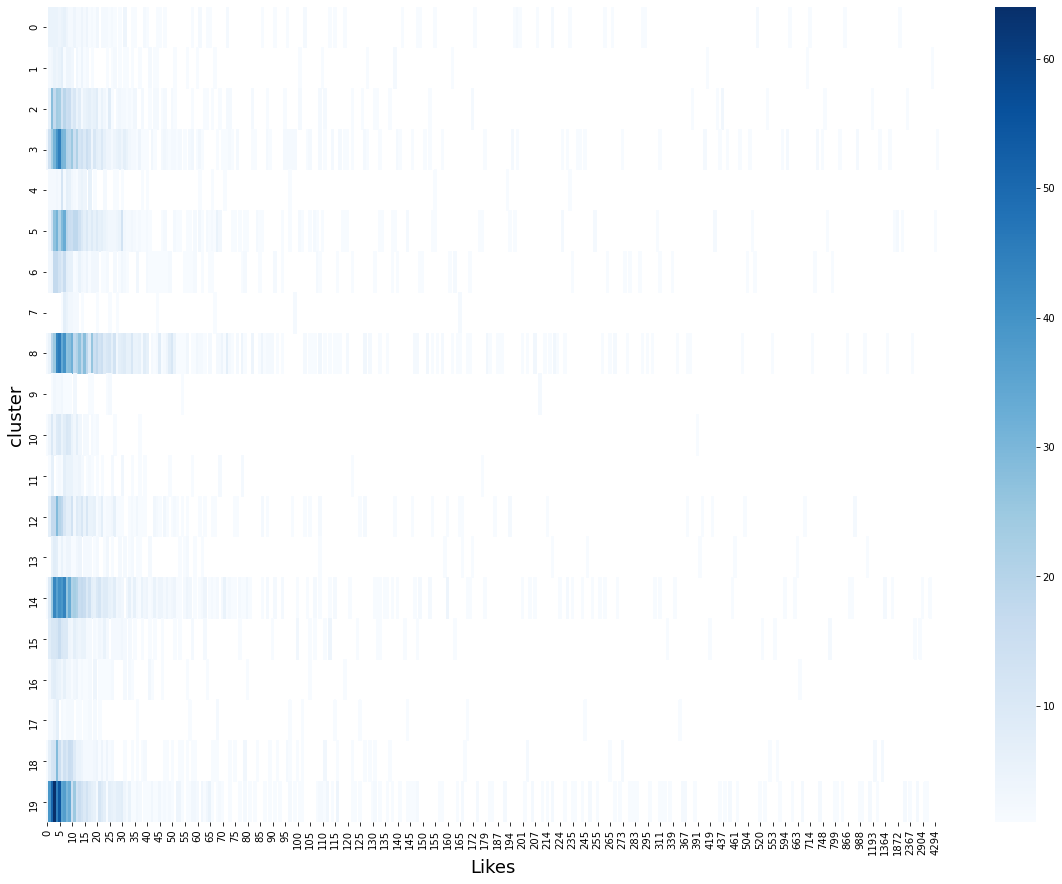

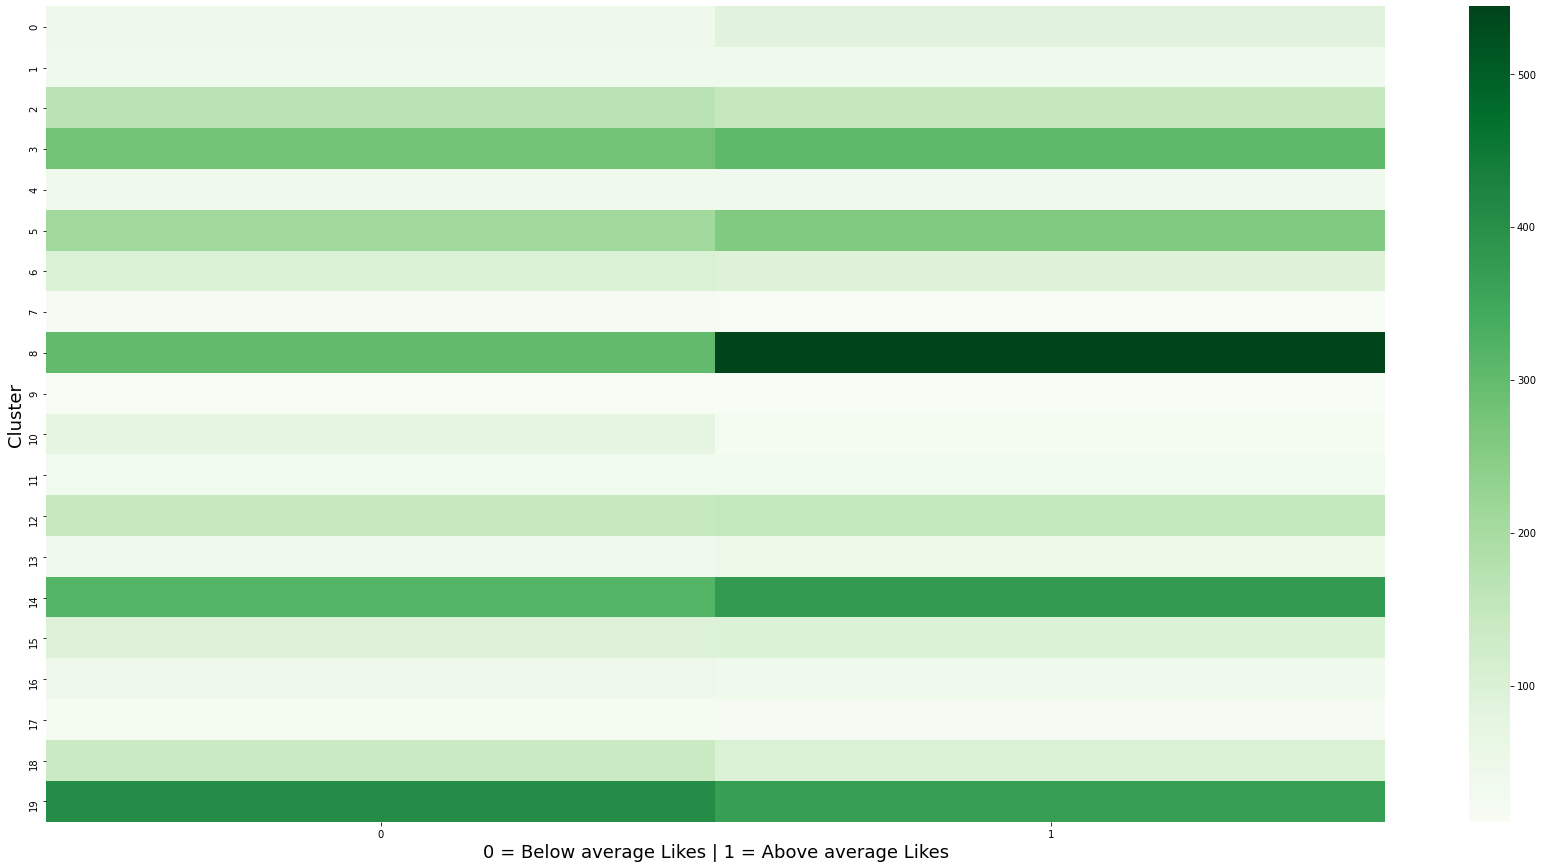

In [49]:
#add the cluster label to the data frame
data['cluster'] = kmeans.labels_

#heatplots to demonstrate results 
clusters = data.groupby(['cluster', 'Likes']).size()
fig, ax1 = plt.subplots(figsize = (20, 15))
sns.heatmap(clusters.unstack(level = 'Likes'), ax = ax1, cmap = 'Blues')
ax1.set_xlabel('Likes').set_size(18)
ax1.set_ylabel('cluster').set_size(18)

clusters = data.groupby(['cluster', 'best_words']).size()
fig2, ax2 = plt.subplots(figsize = (30, 15))
sns.heatmap(clusters.unstack(level = 'best_words'), ax = ax2, cmap="Greens")
ax2.set_xlabel('0 = Below average Likes | 1 = Above average Likes').set_size(18)
ax2.set_ylabel('Cluster').set_size(18)

We can further expand the result of the heatmap through countplots to accurately determine the best cluster(s)

In [50]:
#create dataframes for countplots
ua = data.loc[data['best_words'] == 0]
aa = data.loc[data['best_words'] == 1]

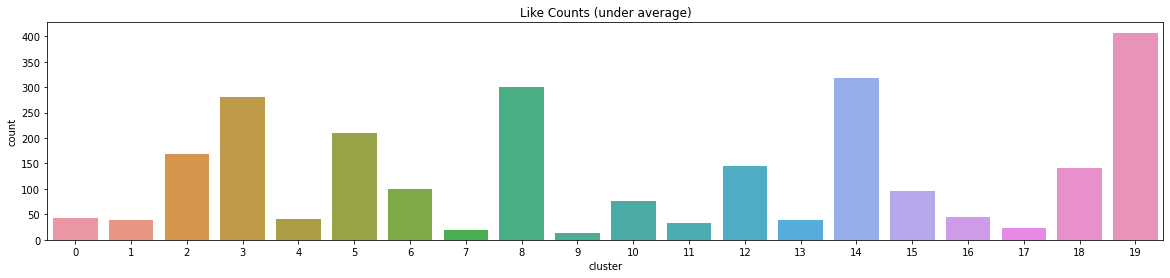

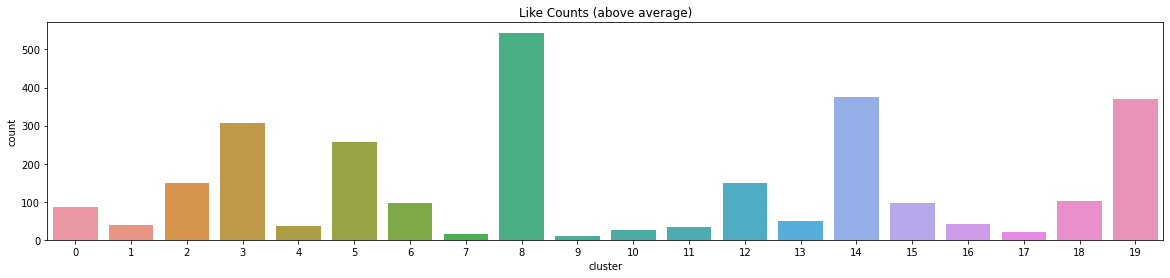

In [51]:
#plot the counts
plt.figure(figsize=(20,4))
sns.countplot(x='cluster', data=ua).set_title("Like Counts (under average)")
plt.show()
plt.figure(figsize=(20,4))
sns.countplot(x='cluster', data=aa).set_title("Like Counts (above average)")
plt.show()

#### Comments:
 > Cluster 8 provides us the most optimal output, to which we can obtain a list of the most optimal words, the success of cluster is shown through the above visualisation. The majority of the TF-IDF words used in this cluster are associated with above average likes. Upon review of the features, it is clear that equipped with a large vocabulary of impactful adjectives and verbs a reviewer can expect a few more likes.

# 2.2 Baseline Model

In [53]:
#re-encode sentiment variable as 0-1 to include in linear regression
data['Sentiment']=le.transform(data['Sentiment'])
data['Sentiment'].unique()

array([1, 0])

In [54]:
# Split your data into training(80%) and testing data (20%) and use random_state=142
train, test = train_test_split(data, test_size=0.2, random_state=142)
#predictor variables for linear regression
lr_vars=['sentiment','Count','cluster','Fans','Comments','Followers', 'Following', 'Paragraphs', 'Total Ratings', 'Average Ratings']
X_train = train.drop(train.columns.difference(lr_vars), 1)
y_train = train['best_words']
X_test = test.drop(test.columns.difference(lr_vars), 1)
y_test = test['best_words']

### 2.2.1 RFE
Prior to constructing a baseline model, we first must examine which features are most important to produce the best model possible.

In [55]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [56]:
estimator = linear_model.LinearRegression()
selector = RFE(estimator,1)
selector.fit(X_train, y_train)
prediction = selector.predict(X_test)
feature_rankings = pd.DataFrame(
    {'features': X_train.columns,
     'ranking': selector.ranking_})
feature_rankings.sort_values(by=['ranking'])

C:\Users\soham\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_features_to_select=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


,features,ranking
2,Average Ratings,1
3,Paragraphs,2
4,Comments,3
8,cluster,4
7,Count,5
1,Fans,6
6,Following,7
5,Followers,8
0,Total Ratings,9


In [57]:
estimator = LinearRegression()
rmse_scores = []
for i in range(1,10):
    selector = RFE(estimator, n_features_to_select=i, step=1)
    selector = selector.fit(X_train, y_train)
    y_test_pred = selector.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print("RMSE score on test set using", i, "features: ", rmse_test)
    rmse_scores.append(rmse_test)

RMSE score on test set using 1 features:  0.4977524368899263
RMSE score on test set using 2 features:  0.5004249875468759
RMSE score on test set using 3 features:  0.48748534709170455
RMSE score on test set using 4 features:  0.4867555279497878
RMSE score on test set using 5 features:  0.486698543677264
RMSE score on test set using 6 features:  0.48079925054394757
RMSE score on test set using 7 features:  0.472815295250526
RMSE score on test set using 8 features:  0.4710401809983167
RMSE score on test set using 9 features:  0.46445834333916647


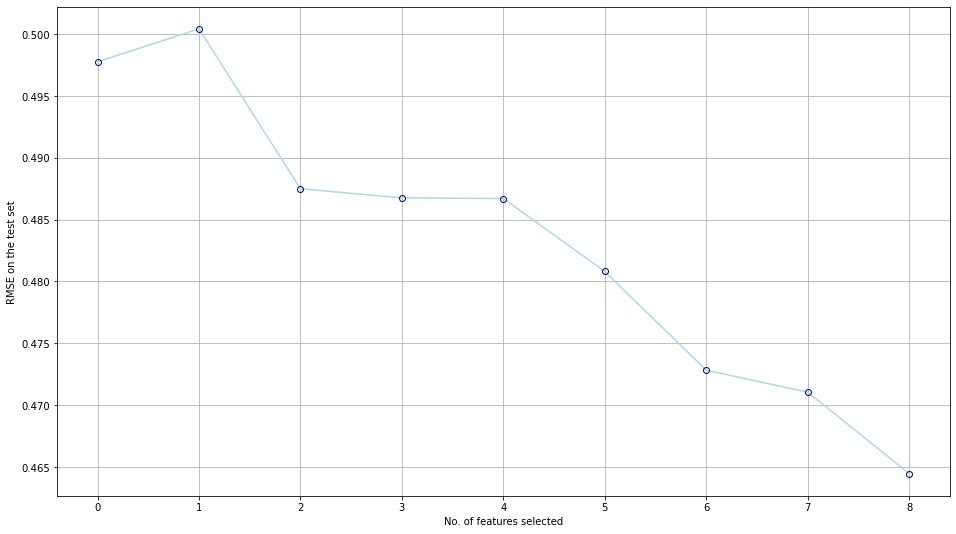

In [58]:
plt.figure(figsize=(16,9))
plt.grid()   
plt.xlabel('No. of features selected')
plt.ylabel('RMSE on the test set')
plt.plot(rmse_scores, marker = 'o', color = 'lightblue', markeredgewidth = 1 ,markeredgecolor = 'DarkBlue', markerfacecolor = 'None')
plt.show()

The optimal number of features in linear regression is the maximum number of features determined through RFE, seen above.

### 2.2.2 Linear Regression
We attempt to fit a linear regression model to our data which is used in prediction.

In [59]:
# Linear Regression
#Initialising the model
model1 = LinearRegression()

#Model training
model1.fit(X_train, y_train)

#Predicting on training and testing data
y_train_hat = model1.predict(X_train)
y_test_hat = model1.predict(X_test)

In [60]:
# Calculating scores on training and testing sets using standard regression metrics
print("Scores on training set: ")
print("RMSE: ", np.sqrt(mean_squared_error(y_train, y_train_hat)))
print("R2: ", r2_score(y_train, y_train_hat))
print("MAE: ", mean_absolute_error(y_train, y_train_hat))
print()
print("Scores on testing set: ")
print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_test_hat)))
print("R2: ", r2_score(y_test, y_test_hat))
print("MAE: ", mean_absolute_error(y_test, y_test_hat))

Scores on training set: 
RMSE:  0.45739905679244025
R2:  0.16077373847087129
MAE:  0.44137885897446416

Scores on testing set: 
RMSE:  0.46445834333916647
R2:  0.13613224523973066
MAE:  0.44724041551664123


#### Comments:
> The performance is relatively poor determined by the low R2 score. Which is to be expected from a basic linear regression model with no applied advanced modelling techniques.

### 2.2.3 Logistic Regression
We attempt to fit a logistic regression model to our data which will be used to predict if likes are less than median or greater than median. 

In [61]:
#Build and train Logistic Regression model
lr = LogisticRegression(random_state=142)
lr.fit(X_train, y_train)
#Use the model to predict testing data
lr_y_test_prediction = lr.predict(X_test)

C:\Users\soham\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [62]:
print("Scores on testing set: ")
print("Accuracy Score: ", accuracy_score(y_test, lr_y_test_prediction))
print("Precision Score:", precision_score(y_test, lr_y_test_prediction, average='macro'))
print("F1 Score:", f1_score(y_test, lr_y_test_prediction, average='macro'))
print("Recall Score:", recall_score(y_test, lr_y_test_prediction, average='macro'))
print()
print("Confusion Matrix:")
print(confusion_matrix(y_test, lr_y_test_prediction))

Scores on testing set: 
Accuracy Score:  0.7434456928838952
Precision Score: 0.7469560052607017
F1 Score: 0.7432431009612854
Recall Score: 0.7452392989551735

Confusion Matrix:
[[412 104]
 [170 382]]


#### Comments:
> The logisic regression model performs a lot better than our linear regression model, initially we were attempting to predict the number of likes a review would receive, however this caused models to return an accuracy score of 0.5%. Thus, applying logistic regression onto likes > median or < median, allows our model to predict if a review will achieve greater than median likes based on the number of paragraphs, word count, total ratings etc. 

## 2.3 Advanced Model

### 2.3.1 Support Vector Machines

In [63]:
#Build and train a SVM model
clf_svm = svm.SVC(kernel='linear')
clf_svm.fit(X_train, y_train)
#Use the model to predict testing data
svm_y_test_prediction = clf_svm.predict(X_test)

In [64]:
#Evaluate the performance of trained logistic regression model
print("Scores on testing set: ")
print("Accuracy Score: ", accuracy_score(y_test, svm_y_test_prediction))
print("Precision Score:", precision_score(y_test, svm_y_test_prediction, average='macro'))
print("F1 Score:", f1_score(y_test, svm_y_test_prediction, average='macro'))
print("Recall Score:", recall_score(y_test, svm_y_test_prediction, average='macro'))
print()
print("Confusion Matrix:")
print(confusion_matrix(y_test, svm_y_test_prediction))

Scores on testing set: 
Accuracy Score:  0.7677902621722846
Precision Score: 0.7700226712104146
F1 Score: 0.7662747478883332
Recall Score: 0.7659462419952814

Confusion Matrix:
[[367 149]
 [ 99 453]]


#### Comments:
> Our advance SVM model slightly improves upon our logistic regression model most notably on the precision score. Thus, SVM is a successful implementation of an advanced model to improve upon results of a baseline model. 

## 3.0 Conclusion
Firstly to answer our first question, Positive reviews do not resonate more than negative reviews. As determined by the counts and means being roughly the same for the number of likes and higher ratings (4.0, 4.5 and 5.0 star ratings) for both the positive and negative sentiments.

Secondly to answer our second question, It seems that shorter reviews are preffered by users as visualised above. The count of likes for words =< the average word count receive more likes then reviews that are longer than average, this is relevant to our dataset and does not account for other predicators such as sentiment this also fails to account for the uneven nature of our data, as we likely have scraped more reviews that are shorter than average as they are the most frequent type of review. This can be appended through further improvement to our data scraping script which would scrape more balanced data. 

Thirdly to answer the third question, The majority of the TF-IDF words used in the successful cluster are associated with above average likes. Upon review of the features, it is clear that equipped with a large vocabulary of impactful adjectives and verbs a reviewer can expect more likes.

As for our prediction models, applying logistic regression onto likes > median or < median, allows our model to predict if a review will achieve greater than median likes based on the predicators. The accuracy score of 75% indicates that despite the low correlation the combination of variables together assist the model in performing somewhat accurately. As for our advanced model...